In [1]:
from utils import *
from text_preprocessing import *
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [2]:
combined_df = preprocess_values(load_combined_df())
combined_df.head()


df shape:  (3000, 9)

rows with null values:  Int64Index([1551, 1552], dtype='int64')
rows that arent twitter:  1

dropped one row, fixed other null by dropping platform col, as unneeded

type of friends col:  int32

 country breakdown:  GB    2991
GG       5
JE       2
IM       1
Name: location.country, dtype: int64

df shape:  (2999, 8)


E:\Projects\bitbucket\fancy-a-challenge-william\utils.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  combined_df = pd.concat([csv_df,txt_df])


,author.properties.friends,author.properties.status_count,author.properties.verified,content.body,location.country,location.latitude,location.longitude,properties.sentiment
0,1689,22566.0,False,Can't believe I'm missing Love Island 😩,GB,51.570448,0.457135,1.0
1,114,1377.0,False,Last tweet about future wedding..... if I actu...,GB,52.969744,-1.172266,1.0
2,568,8375.0,False,"How many times does he wonna say the phrase ""i...",GB,51.394369,0.026299,-1.0
3,1845,19394.0,False,...even better if time travel were invented an...,GB,51.648544,-3.804292,-1.0
4,1617,17922.0,False,@GreenAlty @ShakeyStephens My Mum in mid 80s p...,GB,53.543471,-2.653238,0.0


In [3]:
combined_df['sentiment'] = combined_df['properties.sentiment'].apply(lambda x: 'neg' if x ==-1 else 'neut' if x==0 else "pos")
combined_df['sentiment'].dtype
combined_df[['properties.sentiment','sentiment']].head()

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

combined_df.shape
ros = RandomOverSampler(random_state=777)

X_ROS, y_ROS = ros.fit_sample(combined_df, combined_df['sentiment'])
ros_df = pd.DataFrame(X_ROS,columns=combined_df.columns)
ros_df['sentiment'].value_counts()

data_train,data_test = train_test_split(ros_df,test_size=0.3,random_state=37)


In [4]:
import numpy as np
import pandas as pd
import re

from bs4 import BeautifulSoup

import sys
import os
import csv

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Masking
from keras.layers import Dense, Input, Flatten,GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional,SpatialDropout1D
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping


MAX_SEQUENCE_LENGTH = 200
MAX_NB_WORDS = 20000
VALIDATION_SPLIT = 0.1


def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = string.decode('utf-8')
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

texts = data_train['content.body'].apply(lambda x: preprocess_no_variables(x))
#labels = data_train['sentiment']
labels = data_train['properties.sentiment']

texts

Using TensorFlow backend.


3285    det var vrre n s killarna som snacka spanska v...
424     is  smirking face microphone smiling face with...
168      folded hands folded hands folded hands folded...
757                                             at with  
3753                       blimey exclamation exclamation
2004     try to get tickets  grinning face with big ey...
3161     i feel you face with tears of joy i could do ...
1622    alfie deyes voice is the worst sound on this e...
827                                           never been 
1402     adorable pup xx id maybe have you beg more or...
3174     mee just please red heart person raising hand...
218     found this great venue 'the happy chef chinese...
1683                   yes but i do love sam smith though
858            is not gna stress it anymore sleeping face
1541                      cannot wait face blowing a kiss
3667    a long time by mayer hawthorne is in harrods l...
2898     no worries kidda still enjoying it like smili...
1286          

In [19]:
EMBEDDING_FILE = 'glove.6B.300d.txt'

if not os.path.exists(EMBEDDING_FILE):
    if not os.path.exists('glove.6B.zip'):
        ! wget http://nlp.stanford.edu/data/glove.6B.zip
    if not os.path.exists(EMBEDDING_FILE):
        ! unzip glove.6B.zip
        !rm glove.6B.100d.txt
        !rm glove.6B.50d.txt
        !rm glove.6B.200d.txt
    
import codecs

EMBEDDING_DIM = int(EMBEDDING_FILE.split('.')[-2][:-1])
EMBEDDING_DIM

300

In [6]:
embeddings_index = {}
f = open(os.path.abspath(EMBEDDING_FILE),encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [7]:
data_train['sent'] = data_train['properties.sentiment'].apply(lambda x: x + 1).astype('str')

from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
temp = np.array(data_train['sent']).reshape(-1, 1)
x = onehotencoder.fit_transform(temp).toarray()
labels = x

c:\users\wburke\projects\venv36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
sent_columns=['neg','neut','pos']
y_train = pd.DataFrame(x,columns=sent_columns)
assert(y_train[y_train.isnull().any(axis=1)].empty)
y_train.head()

,neg,neut,pos
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0


In [9]:

print('Shape of data tensor:', len(texts))
print('Shape of label tensor:', len(labels))

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print(data_test.shape)

test_texts= data_test['content.body'].apply(lambda x: preprocess_no_variables(x)).values


Shape of data tensor: 2946
Shape of label tensor: 2946


c:\users\wburke\projects\venv36\lib\site-packages\keras_preprocessing\text.py:177: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


(1263, 9)


In [10]:
test_tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
test_tokenizer.fit_on_texts(test_texts)
test_sequences = test_tokenizer.texts_to_sequences(test_texts)
test_word_index = test_tokenizer.word_index
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(test_data)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

[[   0    0    0 ...    0  738    3]
 [   0    0    0 ...    2 1243   63]
 [   0    0    0 ...   10   15   13]
 ...
 [   0    0    0 ... 3158   12  655]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...  128  624 3159]]


In [11]:
EMBEDDING_DIM = 300
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print ('Length of embedding_matrix:', embedding_matrix.shape[0])
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            mask_zero=False,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)


print('Traing and validation set number of positive and negative reviews')
print (y_train.sum(axis=0))
print (y_val.sum(axis=0))

Length of embedding_matrix: 4947
Traing and validation set number of positive and negative reviews
[887. 881. 884.]
[ 90. 104. 100.]


In [12]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [13]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
sentLayer = SpatialDropout1D(0.1)(embedded_sequences)
l_lstm = Bidirectional(LSTM(64, return_sequences=True))(sentLayer)
x = Bidirectional(GRU(64, return_sequences=True))(l_lstm)

x1 = Attention(MAX_SEQUENCE_LENGTH)(x)
x2 = GlobalAveragePooling1D()(x)
x3 = GlobalMaxPooling1D()(x)
x = Concatenate()([x1, x2, x3])

dense_1 = Dense(256,activation='relu')(x)
dropout_2=Dropout(0.15)(dense_1)
dense_2 = Dense(3, activation='softmax')(dropout_2)

model = Model(sequence_input, dense_2)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     1484100     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 200, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200, 128)     186880      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
bidirectio

In [14]:
filepath="data/predict-goal-weights.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
callbacks_list = [checkpoint,early_stop]

history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=10, batch_size=32,shuffle=True,
                    callbacks=callbacks_list)

c:\users\wburke\projects\venv36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 2652 samples, validate on 294 samples
Epoch 1/10
2652/2652 [==============================] - 74s 28ms/step - loss: 1.0741 - acc: 0.4657 - val_loss: 0.8348 - val_acc: 0.6395

Epoch 00001: val_acc improved from -inf to 0.63946, saving model to predict-goal-weights.best.hdf5
Epoch 2/10
2652/2652 [==============================] - 70s 26ms/step - loss: 0.8409 - acc: 0.6346 - val_loss: 0.6946 - val_acc: 0.7211

Epoch 00002: val_acc improved from 0.63946 to 0.72109, saving model to predict-goal-weights.best.hdf5
Epoch 3/10
2652/2652 [==============================] - 68s 25ms/step - loss: 0.6735 - acc: 0.7315 - val_loss: 0.6696 - val_acc: 0.7075

Epoch 00003: val_acc did not improve from 0.72109
Epoch 4/10
2652/2652 [==============================] - 70s 27ms/step - loss: 0.5264 - acc: 0.7998 - val_loss: 0.6458 - val_acc: 0.7517

Epoch 00004: val_acc improved from 0.72109 to 0.75170, saving model to predict-goal-weights.best.hdf5
Epoch 5/10
2652/2652 [==============================

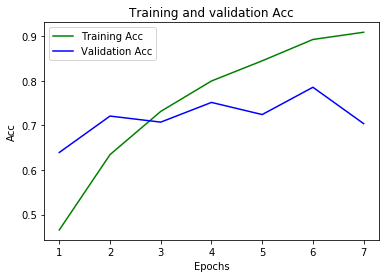

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

In [18]:
csvfile = open('output.csv', 'w') 
writer = csv.writer(csvfile)
writer.writerow(['statement','label'])

a=np.array(model.predict(test_data, batch_size=32, verbose=1))

label_names = ['negative','neutral','positive']

output=[]
for i in range(len(test_texts)):
    text = test_texts[i]
    label_col = label_names[np.argmax(a,axis=1)[i]]
    output_a=[text,label_col]
    output.append(output_a)
    print(label_col,':',text)
print(output)
model.save('data/sentiment-LSTM-Model.h5')
 
writer.writerows(output)
csvfile.close()

1263/1263 [==============================] - 7s 6ms/step
positive :   woof exclamation
neutral : video will be in the morning now
neutral : if you ever gonna sleep at mine just know we are gonna watch joan rivers do not start with me so sexy is not it
neutral : feel like this was created just for you  
neutral : imagine been able to tweet about something fun nope not me have no idea exclamation i am so boring face with tears of joy face with tears of joy
positive :  i am on page # this month exclamation
positive : gee's little laugh is adorable sparkles smiling face see no evil monkey
negative : my mood is pile of poo
positive : when  makes the whole house watch the drivel that is skull skull
neutral :  yes then jack congrats on #zerozerok well done
neutral :   it does not matter how they became that way telling them oh its okay is only going to make it worse
positive :  ha ha blush
neutral : there are places i will not work because of this important that we acknowledge the past 
neutr

positive : me when i get some of  lingeries smiling face with heart eyes smiling face with heart eyes 
positive :        so pretty is not it hopefully have some this yr
neutral : a happy birthday to  have a good one lady
neutral :  lmao why you mention me the same thing twice face with tears of joy face with tears of joy 
negative : luuciidity coome back to mee
neutral : literally want to cry and kill my self 
neutral :  yeah it is a strange one hopefully the purse strings are tightened soon and he will walk like he did at palace
negative :  or get follwed back exclamation
neutral :  missclikeame esta maana estoy de descanso unos vicios pegan
positive :  sorry about that
neutral : happy my back is feeling tonnes better flexed biceps
neutral : this is you  face with tears of joy face with tears of joy 
positive : watching only fools and horses in bed feeling tired sleepy time soon
negative :  oh ok corel painter level up oh like get the #zeroone# upgrade
neutral : you are a dick sleepin

neutral :  
neutral : skatty yatty
neutral :        happy xx 
neutral :  hi guys we are from reading and would love to take your branding to a new level get in touch and we will chat more exclamation
neutral :   thank god for that so in love with 'easy' beating heart
negative : # little penguins penguin penguin sparkling heart chester zoo 
neutral : do explain  do explain are you a serious political journalism programme or what 
neutral : happy birthday girls purple heart party popper hope you enjoy yourself you absolute worldies   xx
neutral : bloody hell 
positive :  that shit was taken off at one# ## today raised hand raised hand you know i know my times
neutral : #one ## bst experimental forecast for the next one# hours fairly fine showery later
neutral : i am at  london kings cross in london gt lon 
negative : nothing better than a quick break with sausages on fire  
neutral : your music has forever provided me with the serenity and peace for everyday stress says a lot about you a

neutral : also some advice for  do not treat audience like they know nothing about politics doc came across as patronising
neutral : see my buddy storming
neutral :    fair point dan bizier numbers i am still on a comedown after sunday haha want another stadium fight exclamation
neutral : really enjoyed my day today cannot wait for more flexed biceps raising hands
neutral : you was just another n gga on the hit list tryna fix your inner issues with a bad bitchh
positive : so orbital were always great mind that day liam howlett made them greater exclamation exclamation smiling face with heart eyes smiling face with heart eyes
positive :  onest gen protect going off in the night second night running no smoke whatsoever how do i stop it doing this
negative : that on person that makes me smile no matter what smiling face xx
negative : i really do appreciate the lovely people on twitter who give me the time of day difficult times but so very grateful god bless andrew
neutral : this happens 

neutral :   i thought i was cool
neutral : looks like the mcu has found its captain marvel star and it is a recent oscar winner  
positive :   woof exclamation
negative : scammed for my knife and fucked over by a betting site what a night this has been
negative : camera roll at the moment loudly crying face face with rolling eyes failin ma computing tomorrow 
positive : having a slight obsession with cornwall and cornish people 
neutral :  you are too kind exclamation exclamation thanks grinning face with big eyes grinning face with big eyes
positive : cad aquela parte que tu disse que ambos tinham que dar ateno
positive :      all in the timing exclamation
neutral : mash up go follow  fb kirbys music 
neutral : oneonety# we do not interact very much seeing your avi i am as of tonight going to change that
neutral : do not work for  wilfully shit
positive :  look at us exclamation puberty hit us so hard we went from 'let us be friends on animal crossing' to 'i am in love with and i am a

neutral :    fair point dan bizier numbers i am still on a comedown after sunday haha want another stadium fight exclamation
neutral : this doc with  is an absolute cracker
neutral : so many amazing things planned over the next year t ibiza creamfeilds log cabin mexico marbella think i better start staying in soon face with rolling eyes
positive : kady and terry have made it all kick off face with tears of joy face with tears of joy
negative : dreams or predictions interesting hypothesis on predictive coding in the brain during sleep 
neutral : good night from uk
neutral : i take payment for airport runs in the form of midnight kebab dinners exclamation belly 
neutral :  he is a great actor would love to see him on the stage but hollywood has him
neutral :  thank you for the follow b 
neutral : atakan bi kere damladan daha zeki kazanr inallah ben her trl nlleri destekliyorum nagi olmad atakan olsun
neutral : diellas seaford 
neutral :   curiosity has peaked exclamation exclamation
nega

neutral : thanks  overwhelmed to win volunteers award proud to represent  thanks  gr# hosts 
positive : listened to she after being out for over a year and i applaud  for being so open a vulnerable to help us all thanks a bunch red heart
positive : eric's wife and daughter dies with one arrow double kill face with tears of joy
neutral :  adrian
neutral :  a warm thank you # following me i very much appreciate your valuable twitter time good # connect 
neutral :  london comiccon exclamation nxt one in oct will let you know join us happy london anime gaming is on in july i prefer multigenre comiccon
neutral :  i am ok thanks yourself
neutral : ughh
neutral :  thanks for the follow daniel exclamation you getting much action in season #
neutral : find out more about dunkies in seaford 
neutral :      
neutral : there is being fat and being fat like how you going to have two hundred chins
[['  woof exclamation', 'positive'], ['video will be in the morning now', 'neutral'], ['if you ever gon